In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='a2e5d174-1cac-4e24-a348-423d3741151e', project_access_token='p-412abd3274a52293593d9f932fb26b8d1fbe1f79')
pc = project.project_context

In [2]:
import pandas as pd
import numpy as np

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb

from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply
import plotly.graph_objs as go

import types
from ibm_botocore.client import Config
import ibm_boto3

import time
import warnings
import types
warnings.filterwarnings('ignore')

%matplotlib inline

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_7886d8c8664241c895087c06d064eb78 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='cy-2q5tup0tP3TZRDA6jrLrjlk5N8AN4bklltWHrACzV',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_7886d8c8664241c895087c06d064eb78.get_object(Bucket='housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',Key='clean.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,YearBuilt,...,Heating_OthW.1,Heating_Wall.1,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,1,60,65.0,8450,1,1,0,7,5,2003,...,0,0,0,0,0,1,1,0,0,0
1,2,20,80.0,9600,1,1,0,6,8,1976,...,0,0,0,0,0,1,1,0,0,0
2,3,60,68.0,11250,1,1,0,7,5,2001,...,0,0,0,0,0,1,1,0,0,0
3,4,70,60.0,9550,1,1,0,7,5,1915,...,0,0,0,0,0,1,1,0,0,0
4,5,60,84.0,14260,1,1,0,8,5,2000,...,0,0,0,0,0,1,1,0,0,0


In [4]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_7886d8c8664241c895087c06d064eb78 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='cy-2q5tup0tP3TZRDA6jrLrjlk5N8AN4bklltWHrACzV',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body2 = client_7886d8c8664241c895087c06d064eb78.get_object(Bucket='housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',Key='clean_test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body2, "__iter__"): body2.__iter__ = types.MethodType( __iter__, body2 )

df_test = pd.read_csv(body2)
df_test.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,YearBuilt,...,Heating_GasW.1,Heating_Grav.1,Heating_Wall.1,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed
0,1461,20,80.0,11622,1,1,0,5,6,1961,...,0,0,0,0,1,0,0,1,0,0
1,1462,20,81.0,14267,1,1,0,6,6,1958,...,0,0,0,0,0,0,1,0,0,0
2,1463,60,74.0,13830,1,1,0,5,5,1997,...,0,0,0,0,1,0,0,1,0,0
3,1464,60,78.0,9978,1,1,0,6,6,1998,...,0,0,0,0,0,0,1,1,0,0
4,1465,120,43.0,5005,1,1,0,8,5,1992,...,0,0,0,0,0,0,1,1,0,0


In [5]:
df.shape, df_test.shape

((1458, 231), (1459, 218))

#### Dataframes do not contain the same number of columns. I need to find the different ones and drop them so I can run the model on the test data later for submission to Kaggle.

In [6]:
df.columns.difference(df_test.columns)

Index(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'Heating_GasA', 'Heating_GasA.1', 'Heating_OthW',
       'Heating_OthW.1', 'HouseStyle_2.5Fin', 'MiscFeature_TenC',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'SalePrice',
       'TotalSF', 'Utilities_NoSeWa'],
      dtype='object')

In [7]:
df = df.drop(columns = ['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
                        'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
                        'Exterior2nd_Other', 'Heating_GasA', 'Heating_GasA.1', 'Heating_OthW',
                        'Heating_OthW.1', 'HouseStyle_2.5Fin', 'MiscFeature_TenC',
                        'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll','TotalSF', 
                        'Utilities_NoSeWa'])

In [8]:
df_test.columns.difference(df.columns)

Index(['Exterior1st_Unknown', 'Exterior2nd_Exterior2nd', 'Functional_None',
       'MSZoning_None', 'SaleType_None', 'Utilities_NonPub'],
      dtype='object')

In [9]:
df_test = df_test.drop(columns = ['Exterior1st_Unknown', 'Exterior2nd_Exterior2nd', 'Functional_None',
                                  'MSZoning_None', 'SaleType_None', 'Utilities_NonPub'])

In [10]:
df.shape, df_test.shape

((1458, 213), (1459, 212))

# Linear Regression

In [16]:
# Set x and y.
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

In [17]:
# Train-Test Split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [18]:
print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)
print('y_train : ', y_train.shape)
print('y_test : ', y_test.shape)

X_train :  (1020, 211)
X_test :  (438, 211)
y_train :  (1020,)
y_test :  (438,)


In [19]:
# Transform the data.
sc = StandardScaler()
sc.fit_transform(X_train)
sc.fit_transform(X_test)

array([[ 2.90852057,  1.40985582,  2.69826127, ...,  0.13639887,
         0.        , -0.11785113],
       [-0.88427175,  0.63367937,  0.01414651, ...,  0.13639887,
         0.        , -0.11785113],
       [ 0.67746626,  0.17710499, -0.19367021, ...,  0.13639887,
         0.        , -0.11785113],
       ..., 
       [ 0.00814997,  0.22276243, -0.27121377, ...,  0.13639887,
         0.        , -0.11785113],
       [ 0.2312554 , -0.18815451,  0.15594044, ...,  0.13639887,
         0.        , -0.11785113],
       [-0.88427175, -0.18815451, -0.24008557, ...,  0.13639887,
         0.        , -0.11785113]])

In [20]:
# Error measure for RMSE scoring.
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [21]:
def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring=scorer, cv=5))
    return(rmse)

In [22]:
def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, X_test, y_test, scoring=scorer, cv=5))
    return(rmse)

In [23]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
print('Linear Regression Score :', lm.score(X_test, y_test))
print("RMSE on Training set :", rmse_cv_train(lm).mean())
print("RMSE on Test set :", rmse_cv_test(lm).mean())

Linear Regression Score : 0.905345497419
RMSE on Training set : 0.126709276344
RMSE on Test set : 0.186532469846


#### RMSE of test set > RMSE of Training set. The model overfit. 

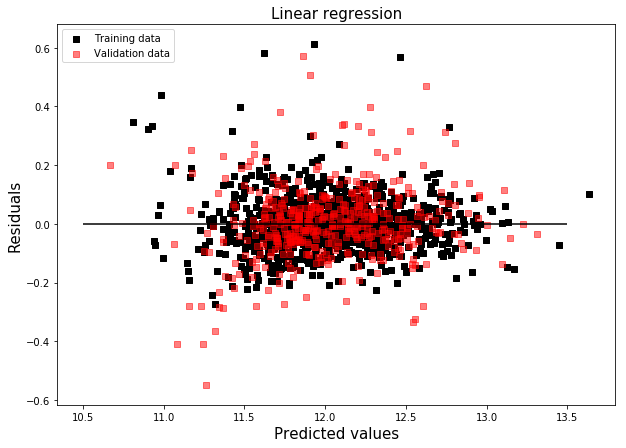

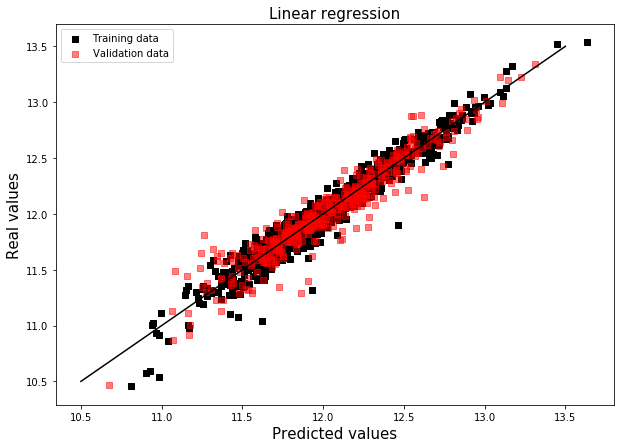

In [25]:
# Look at predictions on training and validation set
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

# Plot residuals
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_pred, y_train_pred - y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_pred, y_test_pred - y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_pred, y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_pred, y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Bagging Regressor

In [27]:
br = BaggingRegressor(LinearRegression(), 
                         n_estimators=50,
                         bootstrap=True)
br.fit(X_train, y_train)

BaggingRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [28]:
print('Bagging Regressor Score :', br.score(X_test, y_test))
print("RMSE on Training set :", rmse_cv_train(br).mean())
print("RMSE on Test set :", rmse_cv_test(br).mean())

Bagging Regressor Score : 0.90967968547
RMSE on Training set : 0.124305464106
RMSE on Test set : 0.248131334957


#### RMSE of test set > RMSE of Training set. The model overfit. 

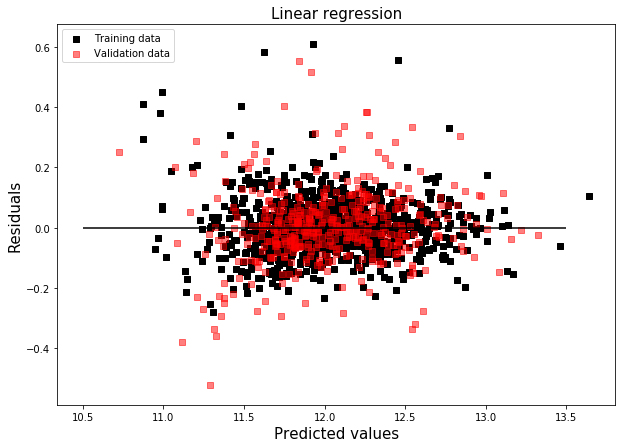

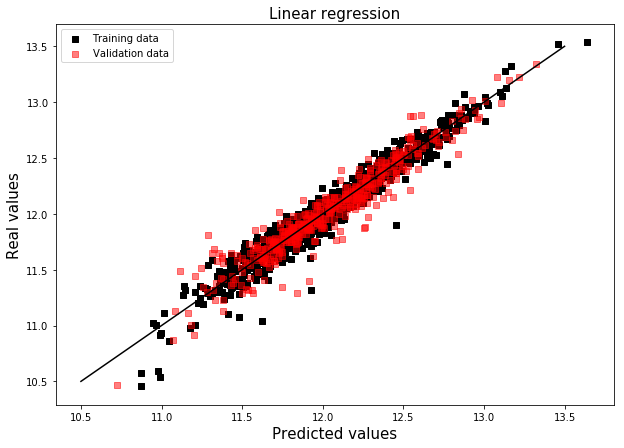

In [29]:
# Look at predictions on training and validation set
y_train_br = br.predict(X_train)
y_test_br = br.predict(X_test)

# Plot residuals
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_br, y_train_br - y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_br, y_test_br - y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_br, y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_br, y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Random Forest

In [30]:
rfr = RandomForestRegressor(bootstrap=True, 
                            n_estimators=100, 
                            n_jobs=1, 
                            random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [31]:
print('Random Forest Regressor Score :', rfr.score(X_test, y_test))
print("Random Forest RMSE on Training set :", rmse_cv_train(rfr).mean())
print("Random Forest RMSE on Test set :", rmse_cv_test(rfr).mean())

Random Forest Regressor Score : 0.888255072211
Random Forest RMSE on Training set : 0.145865454866
Random Forest RMSE on Test set : 0.151004160721


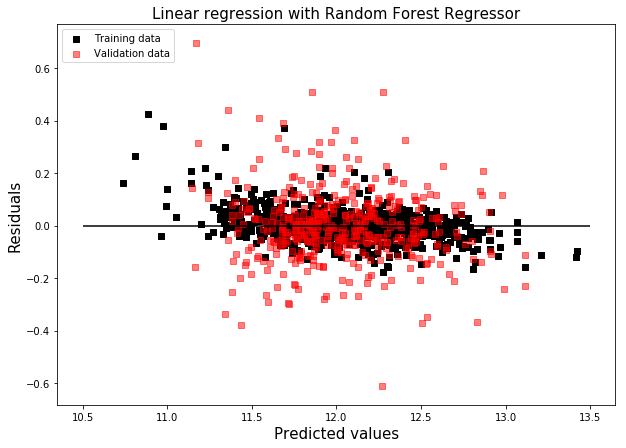

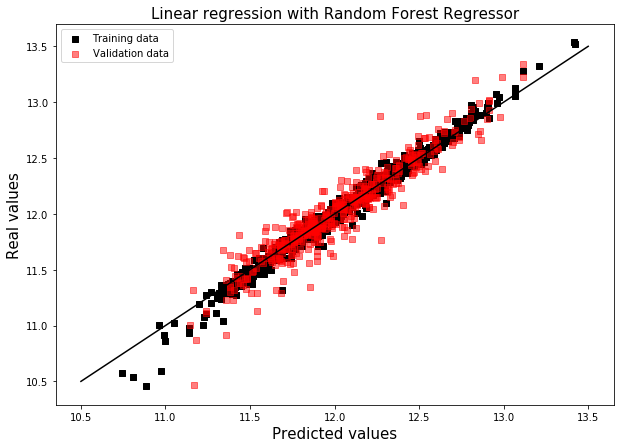

In [34]:
# Look at predictions on training and validation set
y_train_rfr = rfr.predict(X_train)
y_test_rfr = rfr.predict(X_test)

# Plot residuals
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_rfr, y_train_rfr - y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_rfr, y_test_rfr - y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression with Random Forest Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_rfr, y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_rfr, y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression with Random Forest Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Lasso

In [35]:
lasso = make_pipeline(RobustScaler(), 
                      Lasso(alpha = 0.0005, 
                            random_state=1))
lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [36]:
print('Lasso Rigression Score :', lasso.score(X_test, y_test))
print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())

Lasso Rigression Score : 0.925030542719
Lasso RMSE on Training set : 0.116777034009
Lasso RMSE on Test set : 0.135384493648


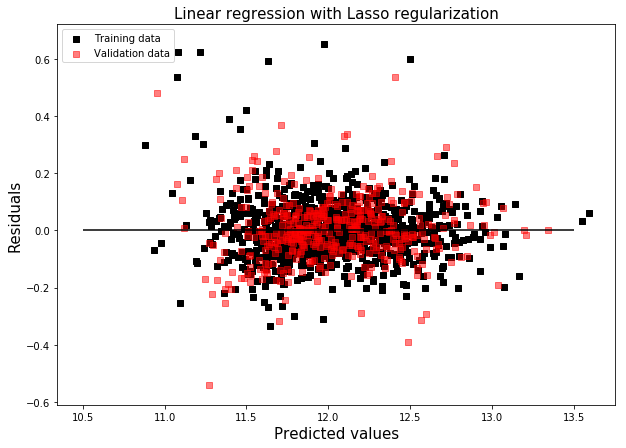

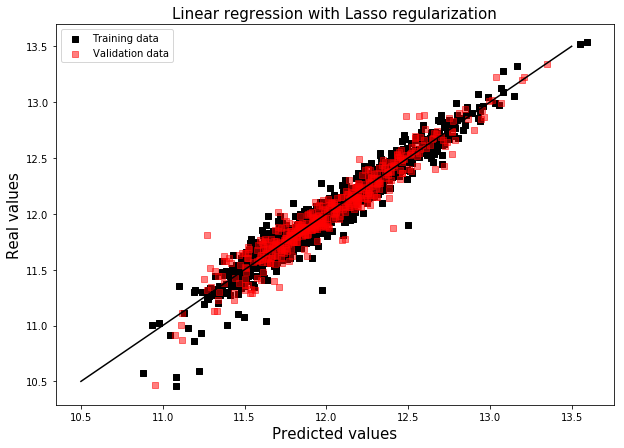

In [40]:
# Look at predictions on training and validation set
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_las, y_train_las - y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_las, y_test_las - y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_las, y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_las, y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Ridge

In [41]:
rr = make_pipeline(RobustScaler(), 
                   Ridge(alpha = 0.0005, 
                         random_state=1))
rr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001))])

In [42]:
print('Ridge Regression Score: ', rr.score(X_test, y_test))
print("Ridge RMSE on Training set :", rmse_cv_train(rr).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(rr).mean())

Ridge Regression Score:  0.905384174933
Ridge RMSE on Training set : 0.126644131488
Ridge RMSE on Test set : 0.181181199554


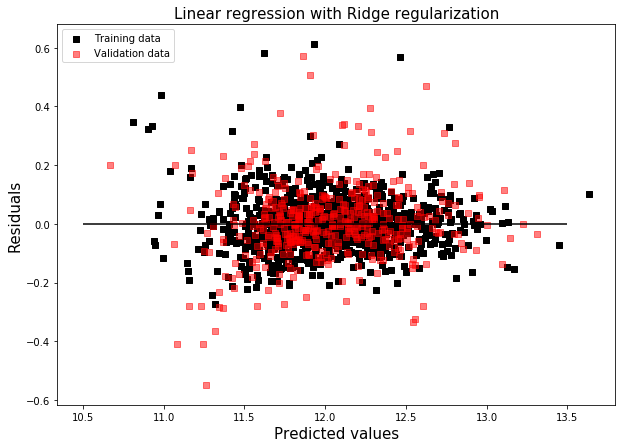

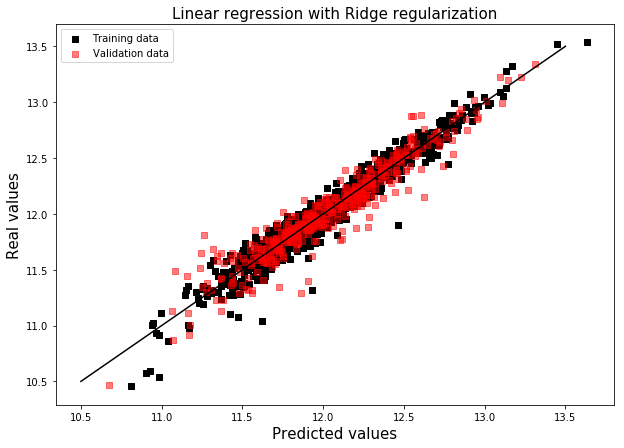

In [43]:
# Look at predictions on training and validation set
y_train_rid = rr.predict(X_train)
y_test_rid = rr.predict(X_test)

# Plot residuals
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_rid, y_train_rid - y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_rid, y_test_rid - y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_rid, y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_rid, y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Elastic Net

In [45]:
e_net = make_pipeline(RobustScaler(), 
                      ElasticNet(alpha=0.0005, 
                                 random_state=3))
e_net.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])

In [46]:
print('Elastic Net Score : ', e_net.score(X_test, y_test))
print("Elastic Net RMSE on Training set :", rmse_cv_train(e_net).mean())
print("Elastic Net RMSE on Test set :", rmse_cv_test(e_net).mean())

Elastic Net Score :  0.923728460163
Elastic Net RMSE on Training set : 0.116302054865
Elastic Net RMSE on Test set : 0.138654375748


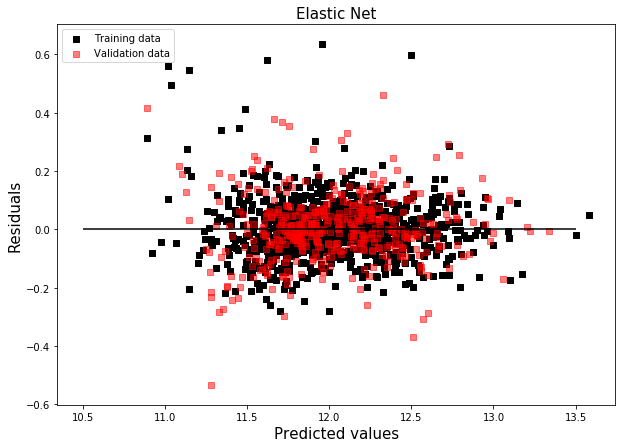

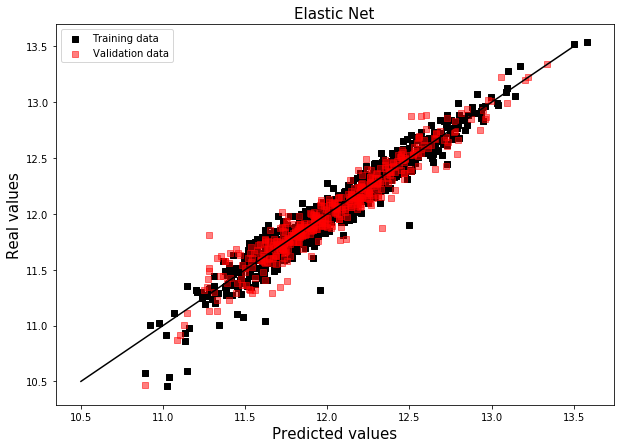

In [47]:
# Look at predictions on training and validation set
y_train_rid = e_net.predict(X_train)
y_test_rid = e_net.predict(X_test)

# Plot residuals
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_rid, y_train_rid - y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_rid, y_test_rid - y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Elastic Net")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_rid, y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_rid, y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Elastic Net")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Gradient Boosting

In [48]:
g_boost = GradientBoostingRegressor(loss='huber', 
                                   learning_rate=0.5, 
                                   n_estimators=3000, 
                                   min_samples_split=10, 
                                   min_samples_leaf=15, 
                                   max_depth=4, 
                                   max_features='sqrt')
g_boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [49]:
print('Gradient Boosting Score : ', g_boost.score(X_test, y_test))
print("Gradient Boosting RMSE on Training set :", rmse_cv_train(g_boost).mean())
print("Gradient Boosting RMSE on Test set :", rmse_cv_test(g_boost).mean())

Gradient Boosting Score :  0.864238073639
Gradient Boosting RMSE on Training set : 0.16076517082
Gradient Boosting RMSE on Test set : 0.164534893446


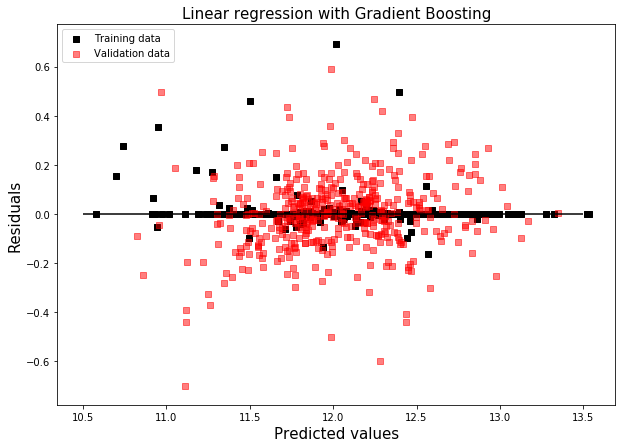

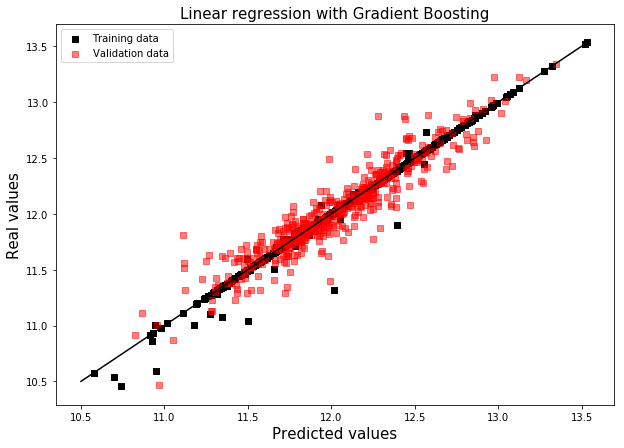

In [52]:
# Look at predictions on training and validation set
y_train_gb = g_boost.predict(X_train)
y_test_gb = g_boost.predict(X_test)

# Plot residuals
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_gb, y_train_gb - y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_gb, y_test_gb - y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression with Gradient Boosting")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_gb, y_train, c = "black", marker = "s", label = "Training data", alpha=1.0)
plt.scatter(y_test_gb, y_test, c = "red", marker = "s", label = "Validation data", alpha=0.5)
plt.title("Linear regression with Gradient Boosting")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# XG Boosting

In [53]:
xg_boost = xgb.XGBRegressor(max_depth=3,
                            learning_rate='0.05', 
                            n_estimators=2200,
                            silent=1,
                            objective='reg:linear',
                            nthread=-1,
                            min_child_weight=1.7817,
                            reg_alpha=0,
                            reg_lambda=0.8571)
xg_boost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate='0.05', max_delta_step=0, max_depth=3,
       min_child_weight=1.7817, missing=None, n_estimators=2200,
       nthread=-1, objective='reg:linear', reg_alpha=0, reg_lambda=0.8571,
       scale_pos_weight=1, seed=0, silent=1, subsample=1)

In [ ]:
xg_boost.score(X_test, y_test)
print("XG Boosting RMSE on Training set :", rmse_cv_train(xg_boost).mean())
print("XG Boosting RMSE on Test set :", rmse_cv_test(xg_boost).mean())

In [ ]:
# Look at predictions on training and validation set
y_train_xg = xg_boost.predict(X_train)
y_test_xg = xg_boost.predict(X_test)

# Plot residuals
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_xg, y_train_xg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_xg, y_test_xg - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with XG Boosting")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.figure(figsize=(10,7))
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.scatter(y_train_xg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_xg, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with XG Boosting")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Run the cleaned test data through the models and make predictions for submission to Kaggle.


### Elastic Net

In [28]:
X2 = df_test.drop(columns = ['Id'], axis=1)

In [44]:
yhat_enet = np.exp(e_net.predict(X2))
pred_enet = pd.DataFrame(yhat_enet)
predict_enet = pd.concat((df_test['Id'], pred_enet), axis=1)
predict_enet.columns=['Id', 'SalePrice']
predict_enet.head()

,Id,SalePrice
0,1461,108817.587965
1,1462,155365.895709
2,1463,169151.785877
3,1464,188536.112505
4,1465,188090.464449


In [46]:
# Save dataframe as csv file to storage
project.save_data(data=predict_enet.to_csv(index=False),file_name='submission_enet.csv',overwrite=True)

{'asset_id': '423310e9-7e8e-4704-ba65-f77a1871fad6',
 'bucket_name': 'housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',
 'file_name': 'submission_enet.csv',
 'message': 'File saved to project storage.'}

#### Elastic Net scored a RMSE of 0.13566 on Kaggle.

### Lasso

In [31]:
yhat_las = np.exp(lasso.predict(X2))
pred_las = pd.DataFrame(yhat_las)
predict_las = pd.concat((df_test['Id'], pred_las), axis=1)
predict_las.columns=['Id', 'SalePrice']
predict_las.head()

,Id,SalePrice
0,1461,109323.477847
1,1462,156956.071454
2,1463,173215.627029
3,1464,193920.864910
4,1465,190274.140718


In [32]:
# Save dataframe as csv file to storage
project.save_data(data=predict_las.to_csv(index=False),file_name='submission_las.csv',overwrite=True)

{'asset_id': '59be6d42-2b1e-4b95-9ead-882801d44e49',
 'bucket_name': 'housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',
 'file_name': 'submission_las.csv',
 'message': 'File saved to project storage.'}

#### Lasso Regression scored a RMSE of 0.12384 on Kaggle which was good enough to put me in the top 32% of submissions. 

### Bagging Regressor

In [30]:
yhat_bag = np.exp(br.predict(X2))
pred_bag = pd.DataFrame(yhat_bag)
predict_bag = pd.concat((df_test['Id'], pred_bag), axis=1)
predict_bag.columns = ['Id', 'SalePrice']
predict_bag.head()

In [38]:
# Save dataframe as csv file to storage
project.save_data(data=predict_bag.to_csv(index=False),file_name='submission_bag.csv',overwrite=True)

{'asset_id': '98981a1a-b4ed-427e-8da5-38ab5a4a37cc',
 'bucket_name': 'housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',
 'file_name': 'submission_bag.csv',
 'message': 'File saved to project storage.'}

#### Bagging Regressor scored a RMSE of 0.16778 on Kaggle.

### Ridge Regression

In [43]:
yhat_rr = np.exp(rr.predict(X2))
pred_rr = pd.DataFrame(yhat_rr)
predict_rr = pd.concat((df_test['Id'], pred_rr), axis=1)
predict_rr.columns = ['Id', 'SalePrice']
predict_rr.head()

In [49]:
# Save dataframe as csv file to storage
project.save_data(data=predict_rr.to_csv(index=False),file_name='submission_rr.csv',overwrite=True)

{'asset_id': 'b292d087-8e13-4662-bd85-105c20738568',
 'bucket_name': 'housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',
 'file_name': 'submission_rr.csv',
 'message': 'File saved to project storage.'}

#### Ridge Regression scored a RMSE of 0.16558 on Kaggle.

### Random Forest

In [30]:
yhat_rfr = np.exp(rfr.predict(X2))
pred_rfr = pd.DataFrame(yhat_rfr)
predict_rfr = pd.concat((df_test['Id'], pred_rfr), axis=1)
predict_rfr.columns = ['Id', 'SalePrice']
predict_rfr.columns = ['Id', 'SalePrice']
predict_rfr.head()

,Id,SalePrice
0,1461,122718.586719
1,1462,147726.748762
2,1463,178002.912221
3,1464,181794.823419
4,1465,191800.191057


In [32]:
# Save dataframe as csv file to storage
project.save_data(data=predict_rfr.to_csv(index=False),file_name='submission_forest.csv',overwrite=True)

{'asset_id': '7188ed3f-a987-4cd2-869b-443006ed0496',
 'bucket_name': 'housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',
 'file_name': 'submission_forest.csv',
 'message': 'File saved to project storage.'}

#### Random Forest scored a RMSE of 0.14998 on Kaggle.

### Gradient Boosting Submission

In [35]:
yhat_gb = np.exp(g_boost.predict(X2))
pred_gb = pd.DataFrame(yhat_gb)
predict_gb = pd.concat((df_test['Id'], pred_gb), axis=1)
predict_gb.columns = ['Id', 'SalePrice']
predict_gb.columns = ['Id', 'SalePrice']
predict_gb.head()

,Id,SalePrice
0,1461,124709.071741
1,1462,134521.816782
2,1463,192490.472541
3,1464,219891.119301
4,1465,176874.988846


In [36]:
# Save dataframe as csv file to storage
project.save_data(data=predict_gb.to_csv(index=False),file_name='submission_gboost.csv',overwrite=True)

{'asset_id': '589e7047-28dd-4cf8-8e2f-6c36fa76f10c',
 'bucket_name': 'housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',
 'file_name': 'submission_gboost.csv',
 'message': 'File saved to project storage.'}

#### Gradient Boosting score a RMSE of 0.17889 on Kaggle.

### XG Boosting Submission

In [39]:
yhat_xgb = np.exp(xg_boost.predict(X2))
pred_xgb = pd.DataFrame(yhat_xgb)
predict_xgb = pd.concat((df_test['Id'], pred_xgb), axis=1)
predict_xgb.columns = ['Id', 'SalePrice']
predict_xgb.columns = ['Id', 'SalePrice']
predict_xgb.head()

,Id,SalePrice
0,1461,123678.882812
1,1462,160168.718750
2,1463,197783.093750
3,1464,192436.125000
4,1465,198754.421875


In [40]:
# Save dataframe as csv file to storage
project.save_data(data=predict_xgb.to_csv(index=False),file_name='submission_xgboost.csv',overwrite=True)

{'asset_id': 'a9bd0f85-cfbf-4564-b049-76b1f2cb723d',
 'bucket_name': 'housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',
 'file_name': 'submission_xgboost.csv',
 'message': 'File saved to project storage.'}

#### XG Boosting scored a RMSE of 0.12888 on Kaggle. Second best model.